In [ ]:
!pip install wfdb

     |████████████████████████████████| 122kB 12.6MB/s 


In [ ]:
from wfdb import io, plot
import wfdb
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
#%matplotlib notebook
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Input
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import time
import keras
from keras.optimizers import RMSprop, Adam
import pywt
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from sklearn.utils import resample
#tf.compat.v1.keras.layers.CuDNNLSTM

In [ ]:
def comments_to_dict(comments):
    key_value_pairs = [comment.split(':') for comment in comments]
    return {pair[0]: pair[1] for pair in key_value_pairs}

In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#load data here
data_path='/gdrive/My Drive/Data set/ECG/ecg_dataset'

In [ ]:
data_folder = 'data'
db = 'ptbdb'
record_names = io.get_record_list(db)

In [ ]:
def record_to_row(record, patient_id):
    row = {}
    row['patient'] = patient_id
    row['name'] = record.record_name
    row['label'] = comments_to_dict(record.comments)['Reason for admission'][1:]
    row['signals'] = record.p_signal
    row['signal_length'] = record.sig_len
    channels = record.sig_name
    signals = record.p_signal.transpose()
    
    row['channels'] = channels
    
    for channel, signal in zip(channels, signals):
        row[channel] = signal
        
    return row

In [ ]:
records = []
for record_name in tqdm(record_names):
    record = io.rdrecord(record_name=os.path.join(data_path, record_name))
    label = comments_to_dict(record.comments)['Reason for admission'][1:]
    patient = record_name.split('/')[0]
    signal_length = record.sig_len
    records.append({'name':record_name, 'label':label, 'patient':patient, 'signal_length':signal_length})
    
channels = record.sig_name
df_records = pd.DataFrame(records)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
df_records.shape

(549, 4)

In [ ]:
selected_labels = [
    'Healthy control',
    'Myocardial infarction'
    ]
df_selected = df_records.loc[df_records['label'].isin(selected_labels)]
label_map = {label: value for label, value in zip(selected_labels, range(len(selected_labels)))}

In [ ]:
df_selected.shape

(448, 4)

In [ ]:
test_patients = []
train_patients = []
test_size = 0.2
channels
for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients)*test_size)
    test_patients+=list(np.random.choice(patients, n_test, replace=False))
    train_patients+=list(patients[np.isin(patients, test_patients, invert=True)])

In [ ]:
def make_whole_set(df_data, channels, label_map, record_id,window_size):
    n_windows = df_data.shape[0]
    
    min_length = df_data['signal_length'].min()

    if window_size is None:
      window_size = min_length

    dataX = np.zeros((n_windows, len(channels), window_size))
    dataY = np.zeros((n_windows, len(label_map)))
    
    record_list = []
    
    nth_window = 0
    for i, (patient, record) in enumerate(tqdm(df_data.iterrows())):
        # read the record, get the signal data and transpose it
        signal_data = io.rdrecord(os.path.join(data_path, record['name'])).p_signal[0:window_size].transpose()
       
        dataX[i] = np.array(signal_data)
        dataY[i][label_map[record.label]] = 1
        
        
        if record_id:
            record_list = [record['name']]
        
    return dataX, dataY, record_list,window_size

In [ ]:
def make_set(df_data, channels, label_map, record_id, window_size=1024):
    n_windows = 0
    
    for _, record in tqdm(df_data.iterrows()):
        n_windows+= record['signal_length']//window_size

    dataX = np.zeros((n_windows, len(channels), window_size))
    dataY = np.zeros((n_windows, len(label_map)))
    
    record_list = []
    
    nth_window = 0
    for i, (patient, record) in enumerate(tqdm(df_data.iterrows())):
        # read the record, get the signal data and transpose it
        signal_data = io.rdrecord(os.path.join(data_path, record['name'])).p_signal.transpose()
        n_rows = signal_data.shape[-1]
        n_windows = n_rows//window_size
        dataX[nth_window:nth_window+n_windows] = np.array([signal_data[:,i*window_size:(i+1)*window_size] for i in range(n_windows)])
        dataY[nth_window:nth_window+n_windows][:, label_map[record.label]] = 1
        nth_window+=n_windows
        
        if record_id:
            record_list+= n_windows*[record['name']]
        
    return dataX, dataY, record_list




def denoise(data):
    # wavedec
    coeffs = pywt.wavedec(data=data, wavelet='db8', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # threshold
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    rdata = pywt.waverec(coeffs=coeffs, wavelet='db8')
    return rdata

In [ ]:
# df_patient_records = df_records.set_index('patient')
# df_train_patients = df_patient_records.loc[train_patients]
# df_test_patients = df_patient_records.loc[test_patients]
# window_size = 1024#df_records['signal_length'].min()
# #trainX, trainY, _ = make_set(df_train_patients, channels, label_map, False, window_size)
# testX, testY, record_list = make_set(df_test_patients, channels, label_map, True, window_size)

In [ ]:
# def make_model(input_shape, output_dim, lstm_layer, dropout=0.2):
#     print("model dim: ", input_shape, output_dim)
#     model = Sequential()
#     model.add(lstm_layer(256, return_sequences=True, input_shape=input_shape, batch_size=None))
#     model.add(Dropout(dropout))
#     model.add(lstm_layer(128, return_sequences=True))
#     model.add(Dropout(dropout))
#     model.add(LSTM(64))
#     model.add(Dropout(dropout))
#     model.add(Dense(output_dim, activation='softmax'))
#     model.compile(loss='binary_crossentropy',metrics=[tf.keras.metrics.BinaryAccuracy()] , optimizer='adam')
    
#     return model

In [ ]:
# class TimeHistory(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.times = []

#     def on_epoch_begin(self, batch, logs={}):
#         self.epoch_time_start = time.time()

#     def on_epoch_end(self, batch, logs={}):
#         self.times.append(time.time() - self.epoch_time_start)

In [ ]:
np.random.seed(1337)
test_patients = []
train_patients = []
test_size = 0.2
channels
for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients)*test_size)
    test_patients+=list(np.random.choice(patients, n_test, replace=False))
    train_patients+=list(patients[np.isin(patients, test_patients, invert=True)])
    
df_patient_records = df_records.set_index('patient')
df_train_patients = df_patient_records.loc[train_patients]
df_test_patients = df_patient_records.loc[test_patients]
#df_records['signal_length'].min()

In [ ]:
df_train_patients.label.value_counts()

Myocardial infarction    301
Healthy control           64
Name: label, dtype: int64

In [ ]:
#up sampling the miniority class of train dataset
df_train_majority = df_train_patients[df_train_patients.label=="Myocardial infarction"]
df_train_minority = df_train_patients[df_train_patients.label=="Healthy control"]
df_train_minority_upsampled = resample(df_train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=301,    # to match majority class
                                 random_state=123) # reproducible results
df_train_patients = pd.concat([df_train_majority, df_train_minority_upsampled])
df_train_patients.label.value_counts()

Myocardial infarction    301
Healthy control          301
Name: label, dtype: int64

In [ ]:
df_test_patients.label.value_counts()

Myocardial infarction    67
Healthy control          16
Name: label, dtype: int64

In [ ]:
#up sampling the miniority class of test dataset
df_test_majority = df_test_patients[df_test_patients.label=="Myocardial infarction"]
df_test_minority = df_test_patients[df_test_patients.label=="Healthy control"]
df_test_minority_upsampled = resample(df_test_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=67,    # to match majority class
                                 random_state=123) # reproducible results
df_test_patients = pd.concat([df_test_majority, df_test_minority_upsampled])
df_test_patients.label.value_counts()

Myocardial infarction    67
Healthy control          67
Name: label, dtype: int64

In [ ]:
trainX, trainY, _,window_size = make_whole_set(df_train_patients, channels, label_map, False, None)

testX, testY, record_list,_ = make_whole_set(df_test_patients, channels, label_map, True, window_size)
# window_size = 1024
# trainX, trainY, _ = make_set(df_train_patients, channels, label_map, False, window_size)
# testX, testY, record_list = make_set(df_test_patients, channels, label_map, True,window_size)

#split validation set
testX, valX, testY, valY = train_test_split(testX, testY, test_size=0.25, random_state=1)

#Shuffle order of train set
trainX, trainY = shuffle(trainX, trainY)

#Since we have a large class inbalance we need to udjust the weights for it.
fractions = 1-trainY.sum(axis=0)/len(trainY)
weights = fractions[trainY.argmax(axis=1)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


In [ ]:
# trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.25, random_state=1)
# #Since we have a large class inbalance we need to udjust the weights for it.
# fractions = 1-trainY.sum(axis=0)/len(trainY)
# weights = fractions[trainY.argmax(axis=1)]
valX.shape

(34, 15, 32000)

In [ ]:
testX.shape

(100, 15, 32000)

In [ ]:
trainX.shape

(602, 15, 32000)

In [ ]:
trainY.shape

(602, 2)

In [ ]:
len(weights)

602

In [ ]:
for i in range(len(trainX)):
  for j in range(0,14):
    trainX[i][j] = denoise(trainX[i][j])

In [ ]:
for i in range(len(testX)):
  for j in range(0,14):
    trainX[i][j] = denoise(trainX[i][j])

In [ ]:
for i in range(len(valX)):
  for j in range(0,14):
    valX[i][j] = denoise(valX[i][j])

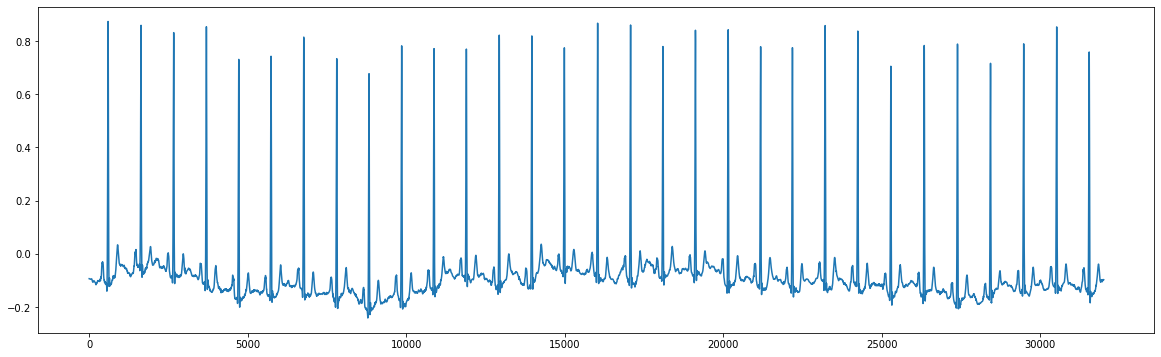

In [ ]:
import matplotlib.pyplot as plt2
plt2.figure(figsize=(20,6)) 
plt2.plot(valX[7][0])
plt2.show()
#plt2.savefig("/gdrive/My Drive/model_output/first_4096.png")

In [ ]:
def buildModel():

    newModel = tf.keras.models.Sequential([
                                           
        tf.keras.layers.InputLayer(input_shape=(15,32000)),

        tf.keras.layers.Conv1D(filters=4, kernel_size=21, strides=1, padding='SAME', activation='relu'),
       
        tf.keras.layers.AvgPool1D(pool_size=1, strides=4, padding='SAME'),
        
        tf.keras.layers.Conv1D(filters=16, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        
        tf.keras.layers.AvgPool1D(pool_size=1, strides=4, padding='SAME'),
       
        tf.keras.layers.Conv1D(filters=32, kernel_size=25, strides=1, padding='SAME', activation='elu'),
       
        tf.keras.layers.AvgPool1D(pool_size=1, strides=8, padding='SAME'),
       
        tf.keras.layers.Conv1D(filters=64, kernel_size=27, strides=1, padding='SAME', activation='relu'),
       
        tf.keras.layers.Flatten(),
       
        tf.keras.layers.Dense(128, activation='relu'),
       
        tf.keras.layers.Dropout(rate=0.2),
       
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    return newModel

In [ ]:
model_test2 = buildModel()
model_test2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 15, 4)             2688004   
_________________________________________________________________
average_pooling1d_6 (Average (None, 4, 4)              0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 4, 16)             1488      
_________________________________________________________________
average_pooling1d_7 (Average (None, 1, 16)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1, 32)             12832     
_________________________________________________________________
average_pooling1d_8 (Average (None, 1, 32)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 64)            

In [ ]:
  import datetime
  #tbcb = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,  write_graph=True, write_images=True)
  %load_ext tensorboard
  model_test2.compile(optimizer = Adam(lr=0.0000001, epsilon=1e-08, decay=0.0) , 
                  loss = "binary_crossentropy", metrics=["accuracy"])

  log_dir = "logs/fit_dec8/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  model_test2.fit(trainX, trainY, validation_data=(valX, valY),validation_batch_size = 4, epochs=500,
                    batch_size=4 ,callbacks = [tensorboard_callback]
                  )

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/500
151/151 [==============================] - 2s 12ms/step - loss: 0.6931 - accuracy: 0.4824 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/500
151/151 [==============================] - 2s 11ms/step - loss: 0.6930 - accuracy: 0.5834 - val_loss: 0.6932 - val_accuracy: 0.4412
Epoch 3/500
151/151 [==============================] - 2s 10ms/step - loss: 0.6929 - accuracy: 0.5880 - val_loss: 0.6932 - val_accuracy: 0.4412
Epoch 4/500
151/151 [==============================] - 2s 10ms/step - loss: 0.6929 - accuracy: 0.6077 - val_loss: 0.6932 - val_accuracy: 0.4412
Epoch 5/500
151/151 [==============================] - 2s 10ms/step - loss: 0.6929 - accuracy: 0.5992 - val_loss: 0.6932 - val_accuracy: 0.4706
Epoch 6/500
151/151 [==============================] - 2s 11ms/step - loss: 0.6928 - accuracy: 0.6055 - val_loss: 0.6932 - val_accuracy: 0.4706
Epoch 7/500
151/151 [=========================

In [ ]:
# #  weights = 50438
# %load_ext tensorboard
# model_Path = '/gdrive/My Drive/model_output'

# filepath = os.path.join(model_Path, "weights-improvement-{epoch:02d}-bigger.hdf5")
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

# model_name = 'two_classes'
# model_folder = os.path.join(model_Path,'tensorlogs/'+ model_name + "-logs/")

# if not os.path.isdir(model_folder):
#     n_logs = 0
# else:
#     n_logs = len(os.listdir(model_folder))
    
# tensorboard_logs = os.path.join(model_folder, "%inth_run"%n_logs)
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=tensorboard_logs, write_graph=False)
# time_callback = TimeHistory()
# callbacks = [checkpoint, tensorboard_callback, time_callback]

# model = make_model((trainX.shape[1], trainX.shape[2]), trainY.shape[-1], LSTM)

# model.fit(trainX, trainY, validation_data = (valX,valY), epochs=100, batch_size=256,sample_weight=weights, callbacks=callbacks)

In [ ]:
testX.shape

(100, 15, 32000)

In [ ]:
model_test2.evaluate(testX,testY,batch_size=1)

100/100 [==============================] - 1s 3ms/step - loss: 0.6707 - accuracy: 0.6000


[0.6707008481025696, 0.6000000238418579]

In [ ]:
output = model_test2.predict_classes(testX)
output

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1])

In [ ]:
confusion_matrix(testY.argmax(axis=1), output)

array([[35, 17],
       [23, 25]])

In [ ]:
y_pred = output
y_pred

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1])

In [ ]:
y_true = testY.argmax(axis=1)
y_true

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.60      0.67      0.64        52
           1       0.60      0.52      0.56        48

    accuracy                           0.60       100
   macro avg       0.60      0.60      0.60       100
weighted avg       0.60      0.60      0.60       100



In [ ]:
(output == testY.argmax(axis=1)).sum()/len(output)

0.6